In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Descomprimir el ZIP dentro de Colab
!unzip "/content/drive/MyDrive/TESIS/MURA_UCD.zip" -d /content/

Se han truncado las últimas 5000 líneas del flujo de salida.
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10909/study1_negative/
  inflating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10909/study1_negative/image3.png  
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient04442/
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient04442/study1_negative/
  inflating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient04442/study1_negative/image3.png  
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10460/
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10460/study1_negative/
  inflating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10460/study1_negative/image2.png  
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10633/
   creating: /content/co

**ENTRENAMIENTO COMPLETO**

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision.io as io
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from sklearn.metrics import precision_recall_curve

# ================================
#  Configuración del dispositivo (Solo GPU)
# ================================
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
print(f"✅ Usando: {device}")

# ================================
#  Cargar modelo ConvNeXt-Large en GPU
# ================================
model = models.convnext_large(weights="IMAGENET1K_V1")
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Sequential(
    nn.Linear(num_ftrs, 384),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(384, 1)
)
model = model.to(device)
print(f"✅ Modelo cargado en {device}")

# ================================
#  Transformaciones en GPU con más Data Augmentation Mejorado
# ================================
def get_train_transforms(label=None):
    return A.Compose([
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.3),
        A.MotionBlur(p=0.2),
        A.Rotate(limit=20, p=0.5),
        A.RandomResizedCrop(size=(384, 384), scale=(0.85, 1.0), p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])


def get_valid_transforms():
    return A.Compose([
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])

# ================================
#  Dataset con balanceo y oversampling
# ================================
class FractureDataset(Dataset):
    def __init__(self, csv_file, transform=None, oversample=False):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        if oversample:
            class_0 = self.df[self.df['etiqueta'] == 0]
            class_1 = self.df[self.df['etiqueta'] == 1]
            class_1_upsampled = class_1.sample(len(class_0), replace=True)
            self.df = pd.concat([class_0, class_1_upsampled]).sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["ruta"]
        label = int(self.df.iloc[idx]["etiqueta"])
        image = io.read_image(img_path).to(device)
        image = image.repeat(3, 1, 1) if image.shape[0] == 1 else image
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convertir a formato HWC

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]


        return image.to(device), torch.tensor(label, dtype=torch.float32, device=device)

# ================================
# Cargar Dataset y DataLoaders
# ================================
train_csv = "/content/train_UCD.csv"
valid_csv = "/content/valid_UCD.csv"
train_dataset = FractureDataset(train_csv, transform=get_train_transforms(1), oversample=True)
valid_dataset = FractureDataset(valid_csv, transform=get_valid_transforms())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

# ================================
# Definir optimizador, pérdida y scheduler
# ================================
labels_np = train_dataset.df["clase"].values
weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_np), y=labels_np)
pos_weight = torch.tensor(weights[1], dtype=torch.float).to(device)


class CustomWeightedFocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return 0.25 * bce_loss + 0.75 * focal

criterion = CustomWeightedFocalLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def obtener_errores(model, valid_loader, threshold):
    model.eval()
    errores = {"FP": [], "FN": []}
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()
            for j in range(len(labels)):
                ruta = valid_loader.dataset.df.iloc[i*valid_loader.batch_size + j]["ruta"]
                if preds[j] == 1 and labels[j] == 0:
                    errores["FP"].append(ruta)
                elif preds[j] == 0 and labels[j] == 1:
                    errores["FN"].append(ruta)
    return errores


def ajustar_umbral(model, valid_loader):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs).cpu().numpy()
            y_scores.extend(probs)
            y_true.extend(labels.cpu().numpy())

    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

    if len(thresholds) == 0:
        print("¡No se pudo calcular el umbral dinámico. Manteniendo el anterior!")
        return 0.5

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    recall_fractura = recalls[np.argmax(f1_scores)]
    precision_fractura = precisions[np.argmax(f1_scores)]

    # Ajustar umbral dinámico para mejorar precisión
    if recall_fractura > 0.85 and precision_fractura < 0.90:
        best_threshold = min(0.52, best_threshold + 0.02)  # Aumentar umbral para mejorar precisión
    elif recall_fractura < 0.80:
        best_threshold = max(0.38, best_threshold - 0.03)  # Bajar umbral si recall es bajo

    return best_threshold


THRESHOLD = 0.5

def predict_tta(model, image_np, n=5):
    model.eval()
    preds = []
    for _ in range(n):
        image_aug = get_valid_transforms()(image=image_np)["image"]
        with torch.no_grad():
            output = model(image_aug.unsqueeze(0).to(device))
            prob = torch.sigmoid(output).item()
            preds.append(prob)
    return np.mean(preds)


# ================================
# Entrenamiento con Fine-Tuning Progresivo
# ================================
for param in model.features.parameters():
    param.requires_grad = False

EPOCHS = 30
def save_checkpoint(epoch, model, optimizer, path="/content/drive/MyDrive/TESIS/MURA_UCD/ModeloCompleto.pth"):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(state, path)
    print(f"✅ Checkpoint guardado en la época {epoch}.")

def load_checkpoint(model, optimizer, path="/content/drive/MyDrive/TESIS/MURA_UCD/ModeloCompleto.pth"):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"✅ Checkpoint cargado desde la época {start_epoch}.")
        return start_epoch
    print(" No se encontró checkpoint. Iniciando desde la época 0.")
    return 0

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    # Definir coordenadas para la región cortada
    cx = np.random.randint(x.shape[2])
    cy = np.random.randint(x.shape[3])
    w = x.shape[2] // 2
    h = x.shape[3] // 2

    bbx1 = np.clip(cx - w // 2, 0, x.shape[2])
    bby1 = np.clip(cy - h // 2, 0, x.shape[3])
    bbx2 = np.clip(cx + w // 2, 0, x.shape[2])
    bby2 = np.clip(cy + h // 2, 0, x.shape[3])

    # Aplicar CutMix
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    y_a, y_b = y, y[index]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.shape[2] * x.shape[3]))

    return x, y_a, y_b, lam


# Verificar y cargar checkpoint
checkpoint_path = "ModeloCompleto.pth"
start_epoch = load_checkpoint(model, optimizer, checkpoint_path) if os.path.exists(checkpoint_path) else 0
scaler = torch.cuda.amp.GradScaler()

for epoch in range(start_epoch, EPOCHS):
    model.train()

    if epoch == 3:
        for param in model.features[-10:].parameters():  # 🔹 Descongelar más capas antes
            param.requires_grad = True
        optimizer.param_groups[0]['lr'] = 5e-5

    if epoch == 8:
        for param in model.features.parameters():
            param.requires_grad = True
        optimizer.param_groups[0]['lr'] = 1e-5


    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Época {epoch+1}/{EPOCHS}")

    for images, labels in progress_bar:
        optimizer.zero_grad()

        #  Aplicar Mixup (80% de las veces)
        if np.random.rand() < 0.8:
            mixed_images, labels_a, labels_b, lam = cutmix_data(images, labels)
        else:
            mixed_images, labels_a, labels_b, lam = images, labels, labels, 1.0

        with torch.cuda.amp.autocast():
            outputs = model(mixed_images).squeeze(1)
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Aplicar el umbral dinámico en todas las predicciones
        predicted = (torch.sigmoid(outputs) > THRESHOLD).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        progress_bar.set_postfix(loss=train_loss, accuracy=train_accuracy)


    print(f"🔹 Época {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f}")

    #  Ajustar el umbral después de la época 5
    if epoch >= 5:
        new_threshold = ajustar_umbral(model, valid_loader)
        if new_threshold > 0:  # Solo actualizar si el umbral es válido
            THRESHOLD = new_threshold
        print(f" Nuevo umbral dinámico en época {epoch+1}: {THRESHOLD:.2f}")

    if epoch % 5 == 0 and epoch > 0:
        errores = obtener_errores(model, valid_loader, THRESHOLD)

        total_nuevos = 0
        for tipo, rutas in errores.items():
            etiqueta = 1 if tipo == "FN" else 0
            nuevos = pd.DataFrame({"ruta": rutas, "etiqueta": [etiqueta]*len(rutas)})
            train_loader.dataset.df = pd.concat([train_loader.dataset.df, nuevos], ignore_index=True)
            total_nuevos += len(rutas)

        if total_nuevos > 0:
            print(f"📌 Añadidos {total_nuevos} ejemplos (FP y FN) al dataset.")

            # Recargar DataLoader con nuevos datos
            train_loader = DataLoader(train_loader.dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)



    # Guardar checkpoint
    save_checkpoint(epoch, model, optimizer)

print("✅ Entrenamiento finalizado!")

# ================================
# Guardar modelo
# ================================
torch.save(model.state_dict(), "/content/drive/MyDrive/TESIS/MURA_UCD/ModeloCompleto.pth")
print("✅ Modelo guardado!")




✅ Usando: cuda


<ipython-input-7-85baf389e838>:246: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


✅ Modelo cargado en cuda


Época 1/30:   0%|          | 0/590 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 1/30: 100%|██████████| 590/590 [05:17<00:00,  1.86it/s, accuracy=0.659, loss=0.254]


🔹 Época 1/30 - Loss: 0.2542 - Accuracy: 0.6588
✅ Checkpoint guardado en la época 0.


Época 2/30: 100%|██████████| 590/590 [05:13<00:00,  1.88it/s, accuracy=0.689, loss=0.238]


🔹 Época 2/30 - Loss: 0.2380 - Accuracy: 0.6889
✅ Checkpoint guardado en la época 1.


Época 3/30: 100%|██████████| 590/590 [05:12<00:00,  1.89it/s, accuracy=0.693, loss=0.235]


🔹 Época 3/30 - Loss: 0.2351 - Accuracy: 0.6930
✅ Checkpoint guardado en la época 2.


Época 4/30: 100%|██████████| 590/590 [08:58<00:00,  1.09it/s, accuracy=0.74, loss=0.215]


🔹 Época 4/30 - Loss: 0.2154 - Accuracy: 0.7401
✅ Checkpoint guardado en la época 3.


Época 5/30: 100%|██████████| 590/590 [08:40<00:00,  1.13it/s, accuracy=0.783, loss=0.192]


🔹 Época 5/30 - Loss: 0.1923 - Accuracy: 0.7828
✅ Checkpoint guardado en la época 4.


Época 6/30: 100%|██████████| 590/590 [08:40<00:00,  1.13it/s, accuracy=0.8, loss=0.183]


🔹 Época 6/30 - Loss: 0.1832 - Accuracy: 0.8002
 Nuevo umbral dinámico en época 6: 0.55
📌 Añadidos 1352 ejemplos (FP y FN) al dataset.
✅ Checkpoint guardado en la época 5.


Época 7/30:   0%|          | 0/611 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 7/30: 100%|██████████| 611/611 [09:02<00:00,  1.13it/s, accuracy=0.792, loss=0.188]


🔹 Época 7/30 - Loss: 0.1876 - Accuracy: 0.7923
 Nuevo umbral dinámico en época 7: 0.38
✅ Checkpoint guardado en la época 6.


Época 8/30:   0%|          | 0/611 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 8/30: 100%|██████████| 611/611 [08:58<00:00,  1.13it/s, accuracy=0.791, loss=0.177]


🔹 Época 8/30 - Loss: 0.1767 - Accuracy: 0.7913
 Nuevo umbral dinámico en época 8: 0.56
✅ Checkpoint guardado en la época 7.


Época 9/30:   0%|          | 0/611 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 9/30: 100%|██████████| 611/611 [08:58<00:00,  1.13it/s, accuracy=0.83, loss=0.163]


🔹 Época 9/30 - Loss: 0.1630 - Accuracy: 0.8296
 Nuevo umbral dinámico en época 9: 0.39
✅ Checkpoint guardado en la época 8.


Época 10/30:   0%|          | 0/611 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 10/30: 100%|██████████| 611/611 [08:57<00:00,  1.14it/s, accuracy=0.823, loss=0.161]


🔹 Época 10/30 - Loss: 0.1613 - Accuracy: 0.8234
 Nuevo umbral dinámico en época 10: 0.43
✅ Checkpoint guardado en la época 9.


Época 11/30:   0%|          | 0/611 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 11/30: 100%|██████████| 611/611 [08:57<00:00,  1.14it/s, accuracy=0.84, loss=0.157]


🔹 Época 11/30 - Loss: 0.1570 - Accuracy: 0.8396
 Nuevo umbral dinámico en época 11: 0.40
📌 Añadidos 1028 ejemplos (FP y FN) al dataset.
✅ Checkpoint guardado en la época 10.


Época 12/30:   0%|          | 0/627 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 12/30: 100%|██████████| 627/627 [09:19<00:00,  1.12it/s, accuracy=0.823, loss=0.163]


🔹 Época 12/30 - Loss: 0.1630 - Accuracy: 0.8230
 Nuevo umbral dinámico en época 12: 0.47
✅ Checkpoint guardado en la época 11.


Época 13/30:   0%|          | 0/627 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 13/30: 100%|██████████| 627/627 [09:12<00:00,  1.13it/s, accuracy=0.844, loss=0.156]


🔹 Época 13/30 - Loss: 0.1563 - Accuracy: 0.8441
 Nuevo umbral dinámico en época 13: 0.52
✅ Checkpoint guardado en la época 12.


Época 14/30:   0%|          | 0/627 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 14/30: 100%|██████████| 627/627 [09:12<00:00,  1.13it/s, accuracy=0.842, loss=0.16]


🔹 Época 14/30 - Loss: 0.1599 - Accuracy: 0.8418
 Nuevo umbral dinámico en época 14: 0.47
✅ Checkpoint guardado en la época 13.


Época 15/30:   0%|          | 0/627 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 15/30: 100%|██████████| 627/627 [09:12<00:00,  1.14it/s, accuracy=0.853, loss=0.153]


🔹 Época 15/30 - Loss: 0.1530 - Accuracy: 0.8530
 Nuevo umbral dinámico en época 15: 0.63
✅ Checkpoint guardado en la época 14.


Época 16/30:   0%|          | 0/627 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 16/30: 100%|██████████| 627/627 [09:12<00:00,  1.14it/s, accuracy=0.842, loss=0.153]


🔹 Época 16/30 - Loss: 0.1530 - Accuracy: 0.8416
 Nuevo umbral dinámico en época 16: 0.42
📌 Añadidos 644 ejemplos (FP y FN) al dataset.
✅ Checkpoint guardado en la época 15.


Época 17/30:   0%|          | 0/637 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 17/30: 100%|██████████| 637/637 [09:28<00:00,  1.12it/s, accuracy=0.844, loss=0.156]


🔹 Época 17/30 - Loss: 0.1564 - Accuracy: 0.8437
 Nuevo umbral dinámico en época 17: 0.42
✅ Checkpoint guardado en la época 16.


Época 18/30:   0%|          | 0/637 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 18/30: 100%|██████████| 637/637 [09:21<00:00,  1.13it/s, accuracy=0.85, loss=0.152]


🔹 Época 18/30 - Loss: 0.1520 - Accuracy: 0.8501
 Nuevo umbral dinámico en época 18: 0.43
✅ Checkpoint guardado en la época 17.


Época 19/30:   0%|          | 0/637 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 19/30: 100%|██████████| 637/637 [09:21<00:00,  1.13it/s, accuracy=0.853, loss=0.15]


🔹 Época 19/30 - Loss: 0.1498 - Accuracy: 0.8528
 Nuevo umbral dinámico en época 19: 0.30
✅ Checkpoint guardado en la época 18.


Época 20/30:   0%|          | 0/637 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 20/30: 100%|██████████| 637/637 [09:21<00:00,  1.13it/s, accuracy=0.816, loss=0.148]


🔹 Época 20/30 - Loss: 0.1477 - Accuracy: 0.8163
 Nuevo umbral dinámico en época 20: 0.46
✅ Checkpoint guardado en la época 19.


Época 21/30:   0%|          | 0/637 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 21/30: 100%|██████████| 637/637 [09:21<00:00,  1.13it/s, accuracy=0.861, loss=0.147]


🔹 Época 21/30 - Loss: 0.1475 - Accuracy: 0.8607
 Nuevo umbral dinámico en época 21: 0.64
📌 Añadidos 335 ejemplos (FP y FN) al dataset.
✅ Checkpoint guardado en la época 20.


Época 22/30:   0%|          | 0/642 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 22/30: 100%|██████████| 642/642 [09:36<00:00,  1.11it/s, accuracy=0.849, loss=0.146]


🔹 Época 22/30 - Loss: 0.1458 - Accuracy: 0.8491
 Nuevo umbral dinámico en época 22: 0.59
✅ Checkpoint guardado en la época 21.


Época 23/30:   0%|          | 0/642 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 23/30: 100%|██████████| 642/642 [09:25<00:00,  1.13it/s, accuracy=0.866, loss=0.143]


🔹 Época 23/30 - Loss: 0.1434 - Accuracy: 0.8656
 Nuevo umbral dinámico en época 23: 0.53
✅ Checkpoint guardado en la época 22.


Época 24/30:   0%|          | 0/642 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 24/30: 100%|██████████| 642/642 [09:25<00:00,  1.13it/s, accuracy=0.873, loss=0.143]


🔹 Época 24/30 - Loss: 0.1432 - Accuracy: 0.8726
 Nuevo umbral dinámico en época 24: 0.48
✅ Checkpoint guardado en la época 23.


Época 25/30:   0%|          | 0/642 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 25/30: 100%|██████████| 642/642 [09:25<00:00,  1.13it/s, accuracy=0.877, loss=0.14]


🔹 Época 25/30 - Loss: 0.1398 - Accuracy: 0.8768
 Nuevo umbral dinámico en época 25: 0.61
✅ Checkpoint guardado en la época 24.


Época 26/30:   0%|          | 0/642 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 26/30: 100%|██████████| 642/642 [09:26<00:00,  1.13it/s, accuracy=0.873, loss=0.14]


🔹 Época 26/30 - Loss: 0.1399 - Accuracy: 0.8733
 Nuevo umbral dinámico en época 26: 0.35
📌 Añadidos 169 ejemplos (FP y FN) al dataset.
✅ Checkpoint guardado en la época 25.


Época 27/30:   0%|          | 0/645 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 27/30: 100%|██████████| 645/645 [09:28<00:00,  1.14it/s, accuracy=0.856, loss=0.139]


🔹 Época 27/30 - Loss: 0.1390 - Accuracy: 0.8563
 Nuevo umbral dinámico en época 27: 0.64
✅ Checkpoint guardado en la época 26.


Época 28/30:   0%|          | 0/645 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 28/30: 100%|██████████| 645/645 [09:27<00:00,  1.14it/s, accuracy=0.869, loss=0.134]


🔹 Época 28/30 - Loss: 0.1339 - Accuracy: 0.8687
 Nuevo umbral dinámico en época 28: 0.37
✅ Checkpoint guardado en la época 27.


Época 29/30:   0%|          | 0/645 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 29/30: 100%|██████████| 645/645 [09:27<00:00,  1.14it/s, accuracy=0.871, loss=0.135]


🔹 Época 29/30 - Loss: 0.1354 - Accuracy: 0.8710
 Nuevo umbral dinámico en época 29: 0.47
✅ Checkpoint guardado en la época 28.


Época 30/30:   0%|          | 0/645 [00:00<?, ?it/s]<ipython-input-7-85baf389e838>:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 30/30: 100%|██████████| 645/645 [09:28<00:00,  1.13it/s, accuracy=0.893, loss=0.134]


🔹 Época 30/30 - Loss: 0.1344 - Accuracy: 0.8927
 Nuevo umbral dinámico en época 30: 0.40
✅ Checkpoint guardado en la época 29.
✅ Entrenamiento finalizado!
✅ Modelo guardado!


In [ ]:
from sklearn.metrics import classification_report

# Evaluar el modelo en el conjunto de validación
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).round()  # Convertir logits a etiquetas (0 o 1)

        all_labels.extend(labels.cpu().numpy())  # Mover etiquetas a CPU
        all_preds.extend(preds.cpu().numpy())    # Mover predicciones a CPU

# Generar el reporte de clasificación
target_names = ["No Fractura", "Fractura"]
print("\n--- 📊 Reporte de Clasificación ---\n")
print(classification_report(all_labels, all_preds, target_names=target_names))




--- 📊 Reporte de Clasificación ---

              precision    recall  f1-score   support

 No Fractura       0.98      0.99      0.99      4750
    Fractura       0.99      0.98      0.98      3251

    accuracy                           0.99      8001
   macro avg       0.99      0.99      0.99      8001
weighted avg       0.99      0.99      0.99      8001



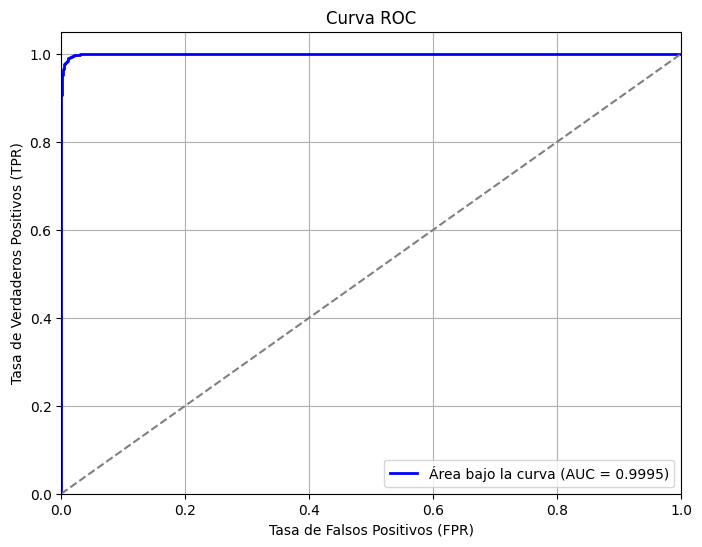

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Modo evaluación
model.eval()

# Listas para etiquetas verdaderas y probabilidades
y_true = []  # Asegúrate de inicializar esta lista antes de usarla
y_scores = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)  # Convertir logits a probabilidades

        # Guardar etiquetas y probabilidades
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Graficar Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f'Área bajo la curva (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Línea de azar
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()


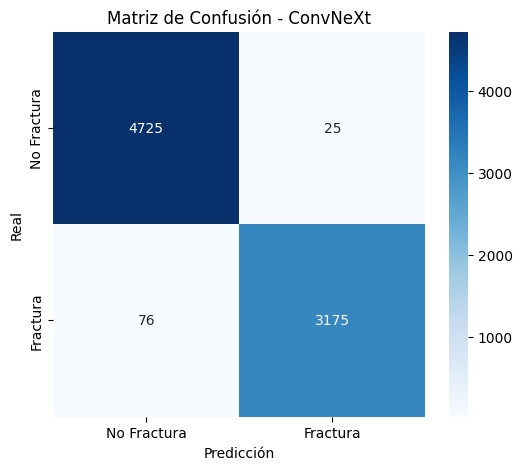

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Asegurar que el modelo esté en modo evaluación
model.eval()

# Listas para guardar predicciones y etiquetas reales
all_preds = []
all_labels = []

# No calcular gradientes durante la evaluación
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)  # Mover a GPU

        outputs = model(images)  # Obtener predicciones
        preds = torch.sigmoid(outputs).round()  # Convertir logits a 0 o 1

        all_preds.extend(preds.cpu().numpy())  # Guardar predicciones
        all_labels.extend(labels.cpu().numpy())  # Guardar etiquetas reales

# Convertir listas a arrays de NumPy
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualizar con seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fractura", "Fractura"], yticklabels=["No Fractura", "Fractura"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - ConvNeXt")
plt.show()